# Likelihood and Nested Sampling

Dark matter spike model analysis (full parameter space).

### Import functions and stuff from pydd

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul,  
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

### Select noise pattern

In [5]:
# Set detector
detector = "LISA"

In [6]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 2 * YR #seconds
    SNR_THRESH = 150.0
    TITLE = "LISA"

### My version of $\texttt{get_signal_system}$

In [7]:
def myget_signal_system() -> Tuple[myDarkMatter, Tuple[float, float]]:
    
    m1 = 1e5 * MSUN # kg
    m2 = 10 * MSUN # kg
    rho6 = 1.17e17 * MSUN / PC**3
    r6 =  PC / 1e6
    gammas = 7/3
    epsv = 0.58
    
    _VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))
    
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)
    q = _VB.q
    logL = np.log10(1 / q**(1/2))
    
    TT_C = 0.0 # time of coalescence
    F_C = _VB.frequency(6 * G * m1 / C**2)
    PHI_C = 0.0 # phase at coalescence
    PN = 0 # zero means don't include PN effects
    
    _DM = myDarkMatter(m1=m1, 
                        m2=m2, 
                        dist=100e6 * PC, 
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=chirp_mass)

    # Frequency range and grids
    F_RANGE_D = find_grid(_DM, T_OBS)
    FS = np.linspace(max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000)

    # Get dL such that SNR is as set above
    _fn = lambda dL: mycalculate_SNR(myDarkMatter(m1=m1, 
                                                  m2=m2, 
                                                  dist=dL, 
                                                  q=q, 
                                                  gammas=gammas, 
                                                  rho6=rho6, 
                                                  r6=r6, 
                                                  epsv=epsv, 
                                                  chirp_mass=chirp_mass), FS[::-1], S_n)
    
    res = root_scalar(lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    DL = res.root
    
    # Redefine DM and VB with "new" distance
    
    _DM_new = myDarkMatter(m1=m1, 
                        m2=m2, 
                        dist=DL, 
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=chirp_mass)
    
    _VB_new = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=DL, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))

    return _VB_new, _DM_new, F_RANGE_D

In [8]:
_VB, _DM, F_RANGE_D = myget_signal_system()

FS = np.linspace(F_RANGE_D[-1], F_RANGE_D[0], 1000)  # coarser grid

In [9]:
PAD_LOW, PAD_HIGH = get_match_pads(FS[::-1])  # padding for likelihood calculation

## Add waveform and noise patterns

For the moment, I am not going to use the $\texttt{get_frequency_noise}$ function, only defining it for further use. 

In [10]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[0] - fs[1]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [11]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[0] - fs[1]
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

In [12]:
# Define the signal: 

signal = waveform(_DM, FS, S_n)[0] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


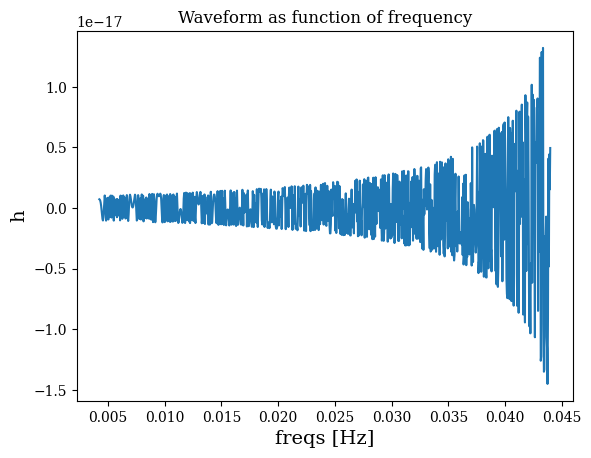

In [13]:
# see the waveform

plt.plot(FS[::-1], signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

# Functions for likelihood calculation

In [14]:
def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) # h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

### Check 'max' likelihood 

In [15]:
maxll = loglikelihood_fft(_DM, _DM, FS, PAD_LOW, PAD_HIGH)
print(maxll)

11360.042181420251


In [16]:
# symmetric priors around true value

true_value = np.array([_DM.chirp_mass, _DM.rho6, _DM.gammas, _DM.Binary_init.q])

print('true value list: ', true_value)

true value list:  [7.91640182e+32 7.91900727e-03 2.33333333e+00 1.00000000e-04]


In [17]:
# set smaller prior range

def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (4,)
    M_c = np.array([0.05]) # M_sun
    gamma = np.array([0.3]) # gamma
    logrho6 = np.array([np.log10(true_value[1]) - 0.5 + 2 * (0.5) * u[2]])
    logq = np.array([np.log10(true_value[3]) - 0.35 + 2 * (0.35) * u[3]])
    return np.array([2 * M_c * (u[0]-0.5), 2 * gamma * (u[1]-0.5), logrho6, logq]).reshape(4,) 


def unpack(x: np.ndarray) -> myDarkMatter:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    
    dMc = x[0]
    dgamma = x[1] 
    dlogrho6 = x[2]
    dlogq = x[3]
    
    Mc = _DM.chirp_mass + dMc * MSUN
    q = 10**(dlogq)
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    rho6 = 10**dlogrho6
    gammas = _DM.gammas + dgamma
    
    DL = _DM.Binary_init.dist
    
    return myDarkMatter(m1=m_1, 
                        m2=m_2, 
                        dist=DL, 
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=_DM.r6, 
                        epsv=_DM.epsv, 
                        chirp_mass=Mc)

def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, _DM, FS, PAD_LOW, PAD_HIGH, S_n)

In [18]:
xs = []
lls = []
for _ in trange(2000):
    xs.append(ptform(np.random.rand(4)))
    lls.append(get_ll_fft(xs[-1]))
              
xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
log_rho6_true = np.log10(true_value[1])
log_q_true = np.log10(true_value[3])
m_true = 0
gammas_true = 0

# only if you use logprior
#log_alpha_true= np.log10((true_value[2]) / (true_value[2] - prior_list_SEARCH[2])) 

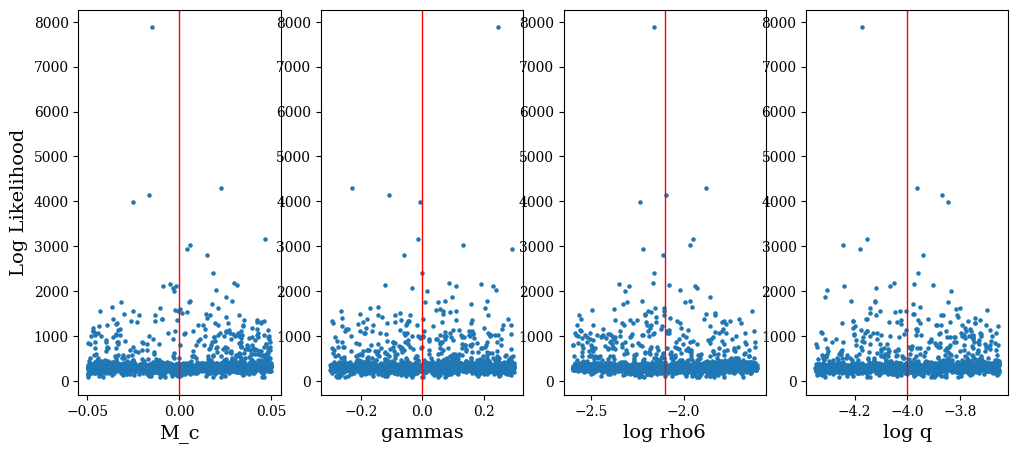

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for i in range(0, 4): 

    ax[i].scatter(xs[:, i], lls, s=5)
    ax[i].set_title('')
    

ax[0].set_ylabel('Log Likelihood')
ax[0].set_xlabel('M_c')
ax[2].set_xlabel('log rho6')
ax[1].set_xlabel('gammas')
ax[3].set_xlabel('log q')

ax[0].axvline(x=m_true, c='red', linewidth=1)
ax[2].axvline(x=log_rho6_true, c='red', linewidth=1)
ax[1].axvline(x=gammas_true, c='red', linewidth=1)
ax[3].axvline(x=log_q_true, c='red', linewidth=1)

## Nested Sampling

In [21]:
with open('sampling-results/dm-results/sampling_results_dm.pkl', 'rb') as f:
    results = pickle.load(f)

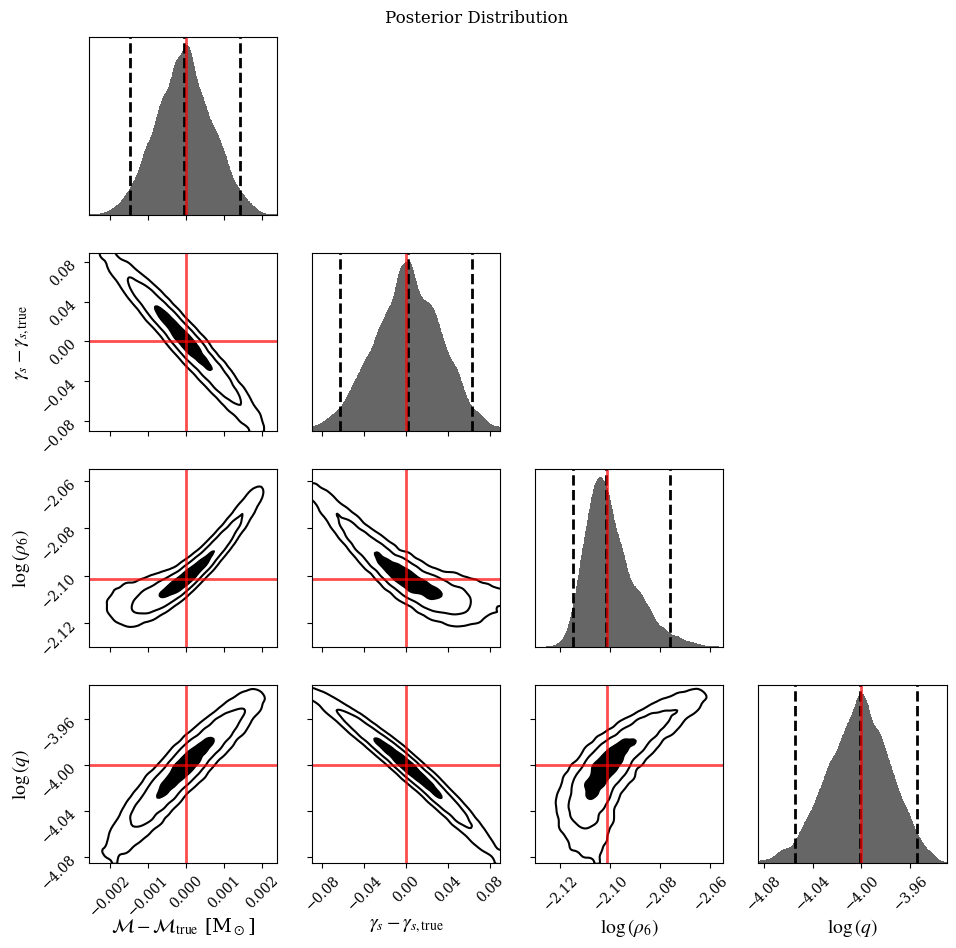

In [22]:
labels = [r"$\mathcal{M} - \mathcal{M}_\mathrm{true}$ [M$_\odot$]", r"$\gamma_s - \gamma_{s,\mathrm{true}}$", r"$\log{(\rho_6)}$", r"$\log{(q)}$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    results, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[0, 0, log_rho6_true, log_q_true], 
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
#plt.savefig('figures/DARKMATTER_noiseless.png')
plt.show()

# Including the noise

In [23]:
with open('sampling-results/dm-results/sampling_results_dmN.pkl', 'rb') as f:
    resultsN = pickle.load(f)

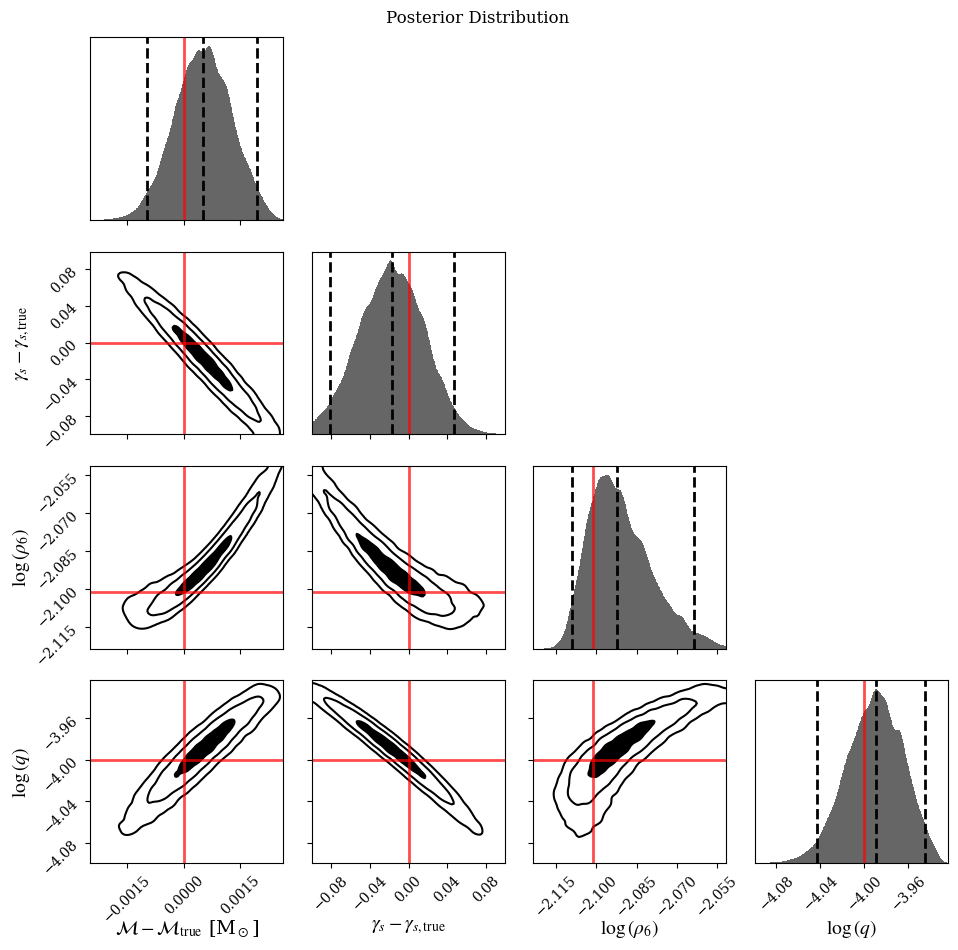

In [24]:
labels = [r"$\mathcal{M} - \mathcal{M}_\mathrm{true}$ [M$_\odot$]", r"$\gamma_s - \gamma_{s,\mathrm{true}}$", r"$\log{(\rho_6)}$", r"$\log{(q)}$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    resultsN, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[0, 0, log_rho6_true, log_q_true], 
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
plt.savefig('figures/DARKMATTER_noisy.png')
plt.show()